In [3]:
# 코랩 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install dython
!pip install xgboost
!pip install lightgbm
!pip install shap

# 필요한 패키지 임포트
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dython.nominal import associations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
import shap

In [5]:
# 데이터 로드
df = pd.read_csv("/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# EDA
- 기초통계량 확인
- 수치형 변수, 범주형 변수 처리
- 시각화

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
# 수치형 데이터 통계량 확인
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [9]:
# 수치형 데이터 제외한 변수 기초 통계확인.
df.describe(exclude = 'number')

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


In [10]:
# 결측치 확인
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [11]:
# TotalCharges가 숫자임에도 불구하고 Object 객체로 설정되어 있음을 확인. => 수치화
# 공백 문자열을 NaN 값으로 대체
df['TotalCharges'] = df['TotalCharges'].replace('', np.nan)
# 'TotalCharges' 열을 숫자형으로 변환, 변환이 불가능한 값은 NaN으로 처리하고 NaN 값은 0으로 대체
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

# SeniorCitizen 데이터도 원래 카테고리 형 데이터인데, 수치형으로 되어 있어 다른 데이터와 유사하게 명목형 데이터로 변환시킴.
df['SeniorCitizen'] = df['SeniorCitizen'].astype('str')


# Target 변수인 Churn을 수치화 => yes: 1, no: 0
# Churn 데이터가 object 데이터이기에, num 데이터 타입인 target를 추가로 삽입하도록 함.
# 이는 수치형 데이터/명목형 데이터 간 상관관계를 측정하기 위함.
df['ChurnTarget'] = df['Churn'].apply(lambda x: 1 if x=='Yes' else 0)
df['ChurnTarget'] = df['Churn'].apply(lambda x: 1 if x=='Yes' else 0)

array([[<Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'MonthlyCharges'}>,
        <Axes: title={'center': 'TotalCharges'}>,
        <Axes: title={'center': 'ChurnTarget'}>, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

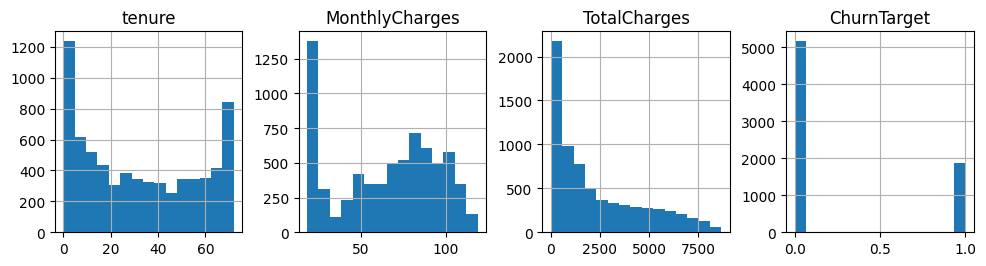

In [12]:
# 수치형 데이터만 히스토그램 시각화
num_features = df.select_dtypes('number').columns

df[num_features].hist(bins=15, figsize=(15, 6), layout=(2, 5))

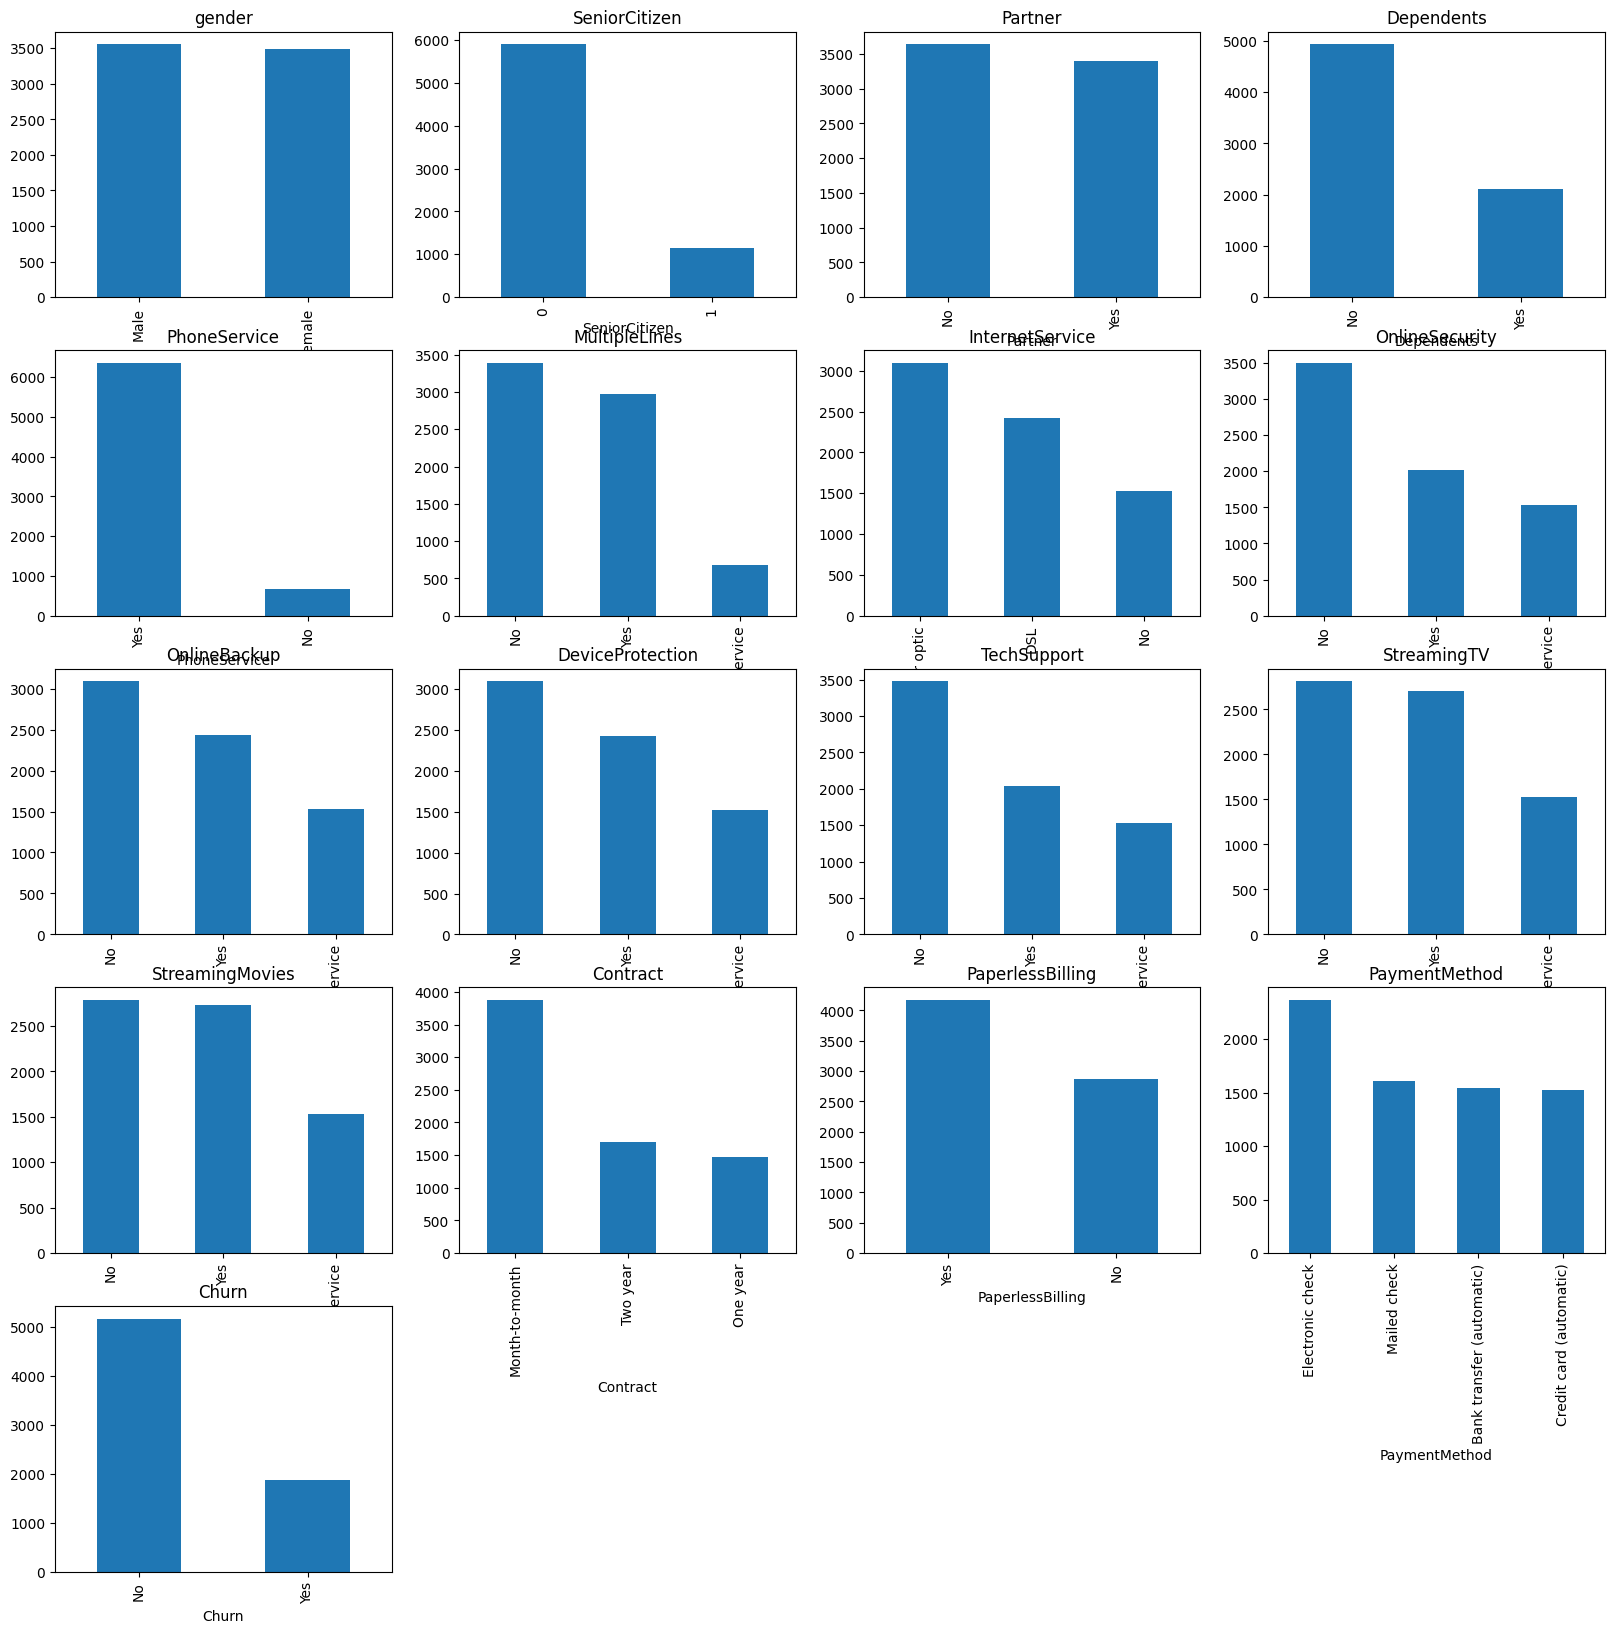

In [13]:
# 카테고리 형 or 명목형 데이터만 시각화
cat_features = df.drop('customerID', axis = 1).select_dtypes(include = 'object').columns

plt.figure(figsize = (20, 20))

for i, col in enumerate(cat_features, 1):
    plt.subplot(5, 4, i)
    df[col].value_counts().plot(kind = 'bar')
    plt.title(col)

Text(0.5, 1.0, 'Correlation Heatmap')

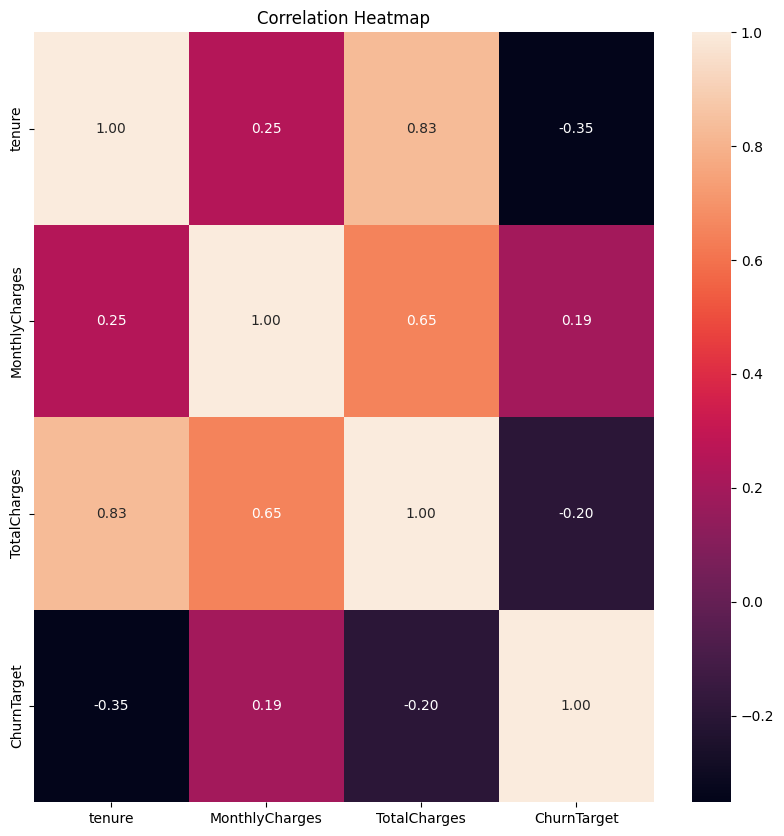

In [14]:
# 수치형 데이터간의 상관관계 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(df[num_features].corr(), annot=True, fmt='.2f')
plt.title('Correlation Heatmap')

<Axes: >

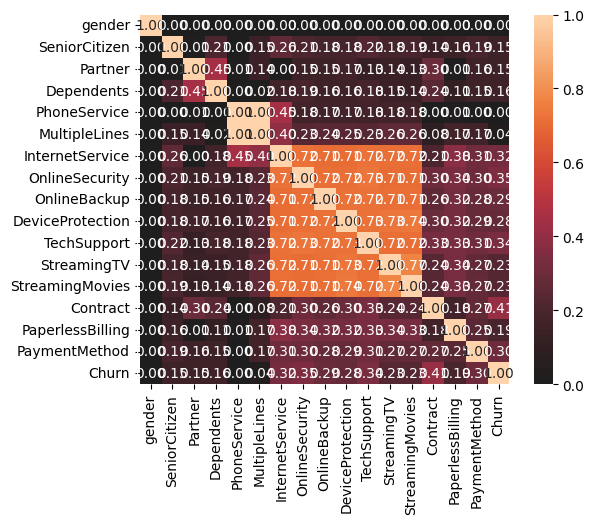

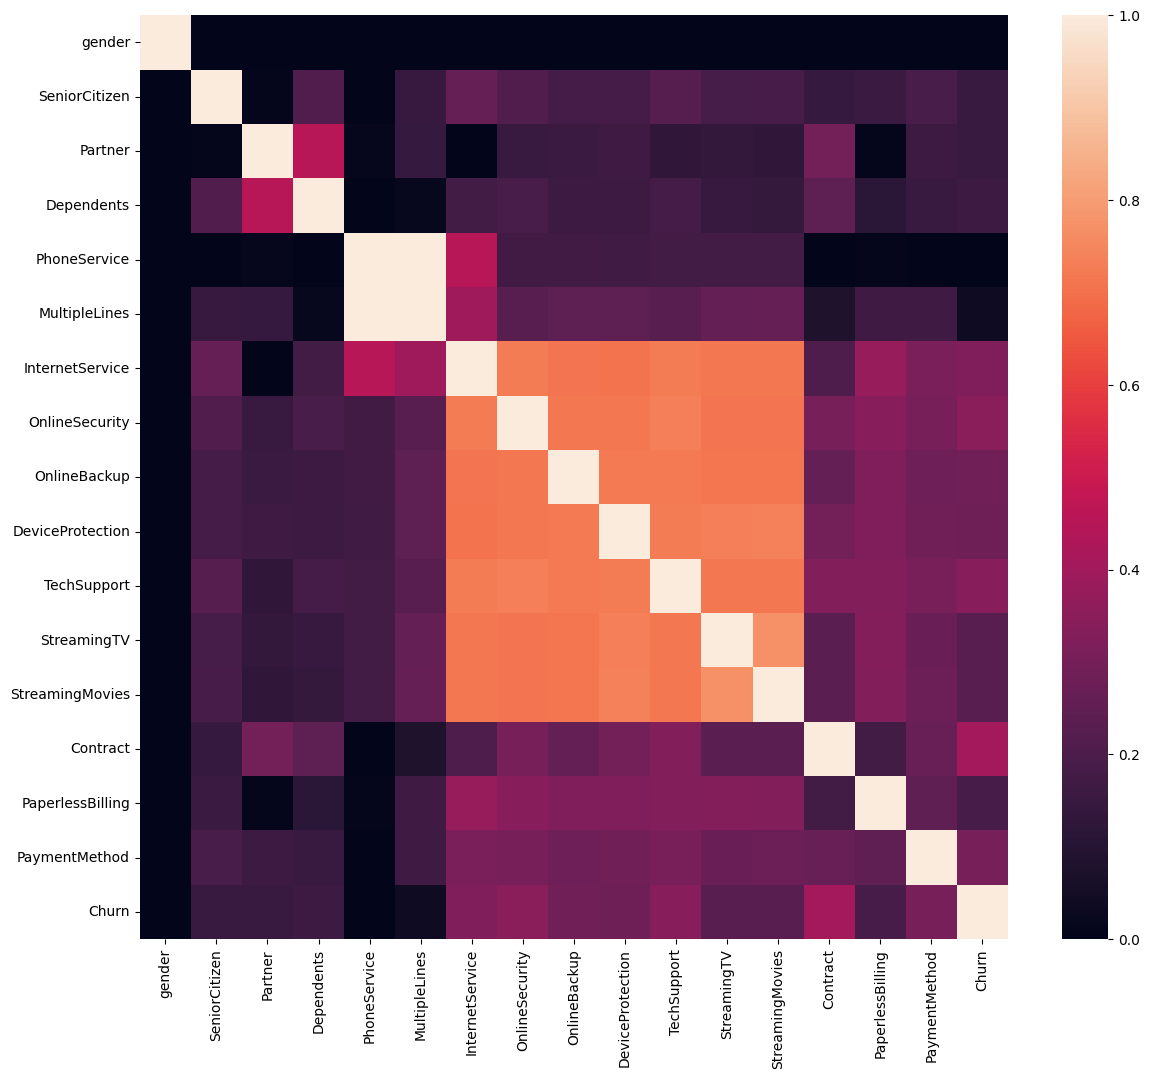

In [15]:
# 범주형 변수들의 연관성 계산
assoc = associations(df[cat_features], nominal_columns='all', plot=False)
# 연관성 행렬 추출
corr_matrix = assoc['corr']
# 히트맵 시각화 준비
plt.figure(figsize=(14, 12))
# 히트맵 생성
sns.heatmap(corr_matrix)

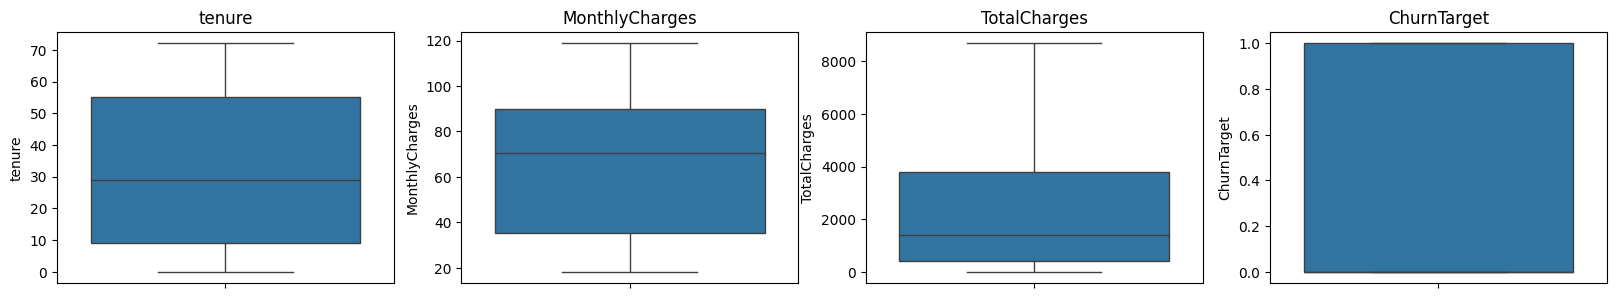

In [16]:
# 수치형 데이터 분포 시각화 (boxplot)
plt.figure(figsize = (20,15))

for i, col in enumerate(num_features, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y = df[col])
    plt.title(col)

# Feature Selection
- 모델에 사용할 Feature를 임계값(상관계수)을 기준으로 선택

In [17]:
# 타겟 변수 설정
target = 'ChurnTarget'

# target 변수를 제외한 수치형 변수들을 선택
num_features = df.select_dtypes(include = [np.number]).columns.drop(target)
# 선택된 수치형 변수들과 타겟 변수들 간의 상관관계를 계산.
correlations = df[num_features].corrwith(df[target])
# 임계치 0.3설정
threshold = 0.3
# 상관계수의 절대값이 0.3을 초과하는 변수들을 선택하여 리스트에 저장.
selected_num_features = correlations[abs(correlations) > threshold].index.tolist()

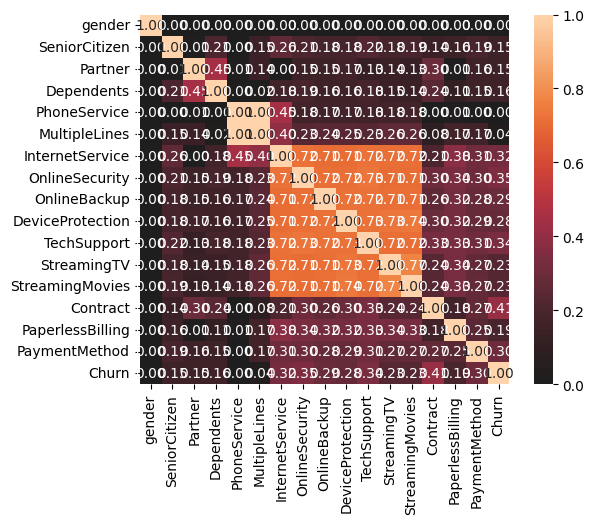

In [18]:
# 타겟 변수 설정
categorical_target = 'Churn'

# 범주형 변수들의 연관성 계산
assoc = associations(df[cat_features], nominal_columns='all', plot=False)
# 연관성 행렬 추출
corr_matrix = assoc['corr']
# 임계치 0.3설정
threshold = 0.3
# 타겟 변수와의 상관관계가 임계치를 초과하는것들만 추출
selected_cat_features = corr_matrix[corr_matrix.loc[categorical_target] > threshold ].index.tolist()

del selected_cat_features[-1]

In [19]:
# 선택한 Feature들 리스트에 추가
selected_features = []
# 수치형 변수 추가
selected_features.extend(selected_num_features)
# 범주형 변수 추가
selected_features.extend(selected_cat_features)

In [20]:
# 모델 예측에 사용될 최종 변수
selected_features

['tenure',
 'InternetService',
 'OnlineSecurity',
 'TechSupport',
 'Contract',
 'PaymentMethod']

In [21]:
target = 'ChurnTarget'

X = df[selected_features]
y = df[target]

cat_features = X.select_dtypes(include = ['object']).columns.tolist()
num_features = X.select_dtypes(include = ['number']).columns.tolist()

In [22]:
# 범주형 변수 원-핫 인코딩
# OneHotEncoder 초기화
encoder = OneHotEncoder(sparse_output=False, dtype=np.float64, handle_unknown='ignore')
# 범주형 특성에 대해 원-핫 인코딩 수행
X_cat = encoder.fit_transform(X[selected_cat_features])
# 원-핫 인코딩된 열 이름 가져오기
X_cat_columns = encoder.get_feature_names_out(selected_cat_features)
# 원-핫 인코딩된 데이터프레임 생성
X_cat_df = pd.DataFrame(X_cat, columns=X_cat_columns, index=X.index)
# 수치형 특성과 원-핫 인코딩된 범주형 특성을 결합
X = pd.concat([X[selected_num_features], X_cat_df], axis=1)

# Modeling
- 그리드 서치 & KFold
- F1 Score, precision, Recall

## Decision Tree

In [23]:
# Decision Tree 모델 초기화
dt = DecisionTreeClassifier()

# 하이퍼파라미터 그리드 설정
param_grid = {
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search 초기화
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)

# Grid Search 수행
grid_search.fit(X, y)

# 최적 모델 추출
dt_best_model = grid_search.best_estimator_

# Scoring 함수 설정
scoring = {
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
}

# 교차검증 수행
precision_scores = cross_val_score(dt_best_model, X, y, cv=5, scoring=scoring['precision'])
recall_scores = cross_val_score(dt_best_model, X, y, cv=5, scoring=scoring['recall'])
f1_scores = cross_val_score(dt_best_model, X, y, cv=5, scoring=scoring['f1'])

# 결과를 데이터프레임으로 정리
dt_results = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(precision_scores))] + ['Mean'],
    'Precision': np.append(precision_scores, precision_scores.mean()),
    'Recall': np.append(recall_scores, recall_scores.mean()),
    'F1-Score': np.append(f1_scores, f1_scores.mean())
})

In [24]:
# 결과 출력
print("Best Hyperparameters:", grid_search.best_params_)
print(dt_results)

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
     Fold  Precision    Recall  F1-Score
0  Fold 1   0.617089  0.521390  0.565217
1  Fold 2   0.648562  0.537433  0.590116
2  Fold 3   0.571429  0.513369  0.540845
3  Fold 4   0.586626  0.517426  0.549858
4  Fold 5   0.580357  0.518717  0.549296
5    Mean   0.600813  0.521667  0.559066


## KNN

In [25]:
# KNN 모델 초기화
knn = KNeighborsClassifier()

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Grid Search 초기화
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)

# Grid Search 수행
grid_search.fit(X, y)

# 최적 모델 추출
knn_best_model = grid_search.best_estimator_

# Scoring 함수 설정
scoring = {
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
}

# 교차검증 수행
precision_scores = cross_val_score(knn_best_model, X, y, cv=5, scoring=scoring['precision'])
recall_scores = cross_val_score(knn_best_model, X, y, cv=5, scoring=scoring['recall'])
f1_scores = cross_val_score(knn_best_model, X, y, cv=5, scoring=scoring['f1'])

# 결과를 데이터프레임으로 정리
knn_results = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(precision_scores))] + ['Mean'],
    'Precision': np.append(precision_scores, precision_scores.mean()),
    'Recall': np.append(recall_scores, recall_scores.mean()),
    'F1-Score': np.append(f1_scores, f1_scores.mean())
})

In [26]:
# 결과 출력
print("Best Hyperparameters:", grid_search.best_params_)
print(knn_results)

Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
     Fold  Precision    Recall  F1-Score
0  Fold 1   0.611276  0.550802  0.579466
1  Fold 2   0.596330  0.521390  0.556348
2  Fold 3   0.588757  0.532086  0.558989
3  Fold 4   0.609428  0.485255  0.540299
4  Fold 5   0.576923  0.481283  0.524781
5    Mean   0.596543  0.514163  0.551976


## Random Forest

In [43]:
# Random Forest 모델 초기화
rf = RandomForestClassifier()

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Grid Search 초기화
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)

# Grid Search 수행
grid_search.fit(X, y)

# 최적 모델 추출
rf_best_model = grid_search.best_estimator_

# Scoring 함수 설정
scoring = {
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
}

# 교차검증 수행
precision_scores = cross_val_score(rf_best_model, X, y, cv=5, scoring=scoring['precision'])
recall_scores = cross_val_score(rf_best_model, X, y, cv=5, scoring=scoring['recall'])
f1_scores = cross_val_score(rf_best_model, X, y, cv=5, scoring=scoring['f1'])

# 결과를 데이터프레임으로 정리
rf_results = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(precision_scores))] + ['Mean'],
    'Precision': np.append(precision_scores, precision_scores.mean()),
    'Recall': np.append(recall_scores, recall_scores.mean()),
    'F1-Score': np.append(f1_scores, f1_scores.mean())
})

In [44]:
# 결과 출력
print("Best Hyperparameters:", grid_search.best_params_)
print(rf_results)

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
     Fold  Precision    Recall  F1-Score
0  Fold 1   0.634375  0.513369  0.571843
1  Fold 2   0.645768  0.534759  0.590258
2  Fold 3   0.602524  0.510695  0.549858
3  Fold 4   0.625407  0.517426  0.563135
4  Fold 5   0.607973  0.494652  0.543860
5    Mean   0.623209  0.514180  0.563791


## SVM

In [47]:
# SVM 모델 초기화
svm = SVC()

# 하이퍼파라미터 그리드 설정
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'sigmoid'],
    'degree': [3, 4, 5]
}

# Grid Search 초기화
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)

# Grid Search 수행
grid_search.fit(X, y)

# 최적 모델 추출
svm_best_model = grid_search.best_estimator_

# Scoring 함수 설정
scoring = {
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
}

# 교차검증 수행
precision_scores = cross_val_score(svm_best_model, X, y, cv=5, scoring=scoring['precision'])
recall_scores = cross_val_score(svm_best_model, X, y, cv=5, scoring=scoring['recall'])
f1_scores = cross_val_score(svm_best_model, X, y, cv=5, scoring=scoring['f1'])

# 결과를 데이터프레임으로 정리
svm_results = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(precision_scores))] + ['Mean'],
    'Precision': np.append(precision_scores, precision_scores.mean()),
    'Recall': np.append(recall_scores, recall_scores.mean()),
    'F1-Score': np.append(f1_scores, f1_scores.mean())
})

In [48]:
# 결과 출력
print("Best Hyperparameters:", grid_search.best_params_)
print(svm_results)

Best Hyperparameters: {'C': 0.1, 'degree': 3, 'kernel': 'linear'}
     Fold  Precision    Recall  F1-Score
0  Fold 1   0.647436  0.540107  0.588921
1  Fold 2   0.663333  0.532086  0.590504
2  Fold 3   0.615108  0.457219  0.524540
3  Fold 4   0.635484  0.528150  0.576867
4  Fold 5   0.645522  0.462567  0.538941
5    Mean   0.641377  0.504026  0.563955


## XGBoost

In [58]:
# XGBoost 모델 초기화
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5]
}

# Grid Search 초기화
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)

# Grid Search 수행
grid_search.fit(X, y)

# 최적 모델 추출
xgb_best_model = grid_search.best_estimator_

# Scoring 함수 설정
scoring = {
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
}

# 교차검증 수행
precision_scores = cross_val_score(xgb_best_model, X, y, cv=5, scoring=scoring['precision'])
recall_scores = cross_val_score(xgb_best_model, X, y, cv=5, scoring=scoring['recall'])
f1_scores = cross_val_score(xgb_best_model, X, y, cv=5, scoring=scoring['f1'])

# 결과를 데이터프레임으로 정리
xgb_results = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(precision_scores))] + ['Mean'],
    'Precision': np.append(precision_scores, precision_scores.mean()),
    'Recall': np.append(recall_scores, recall_scores.mean()),
    'F1-Score': np.append(f1_scores, f1_scores.mean())
})


In [59]:
# 결과 출력
print("Best Hyperparameters:", grid_search.best_params_)
print(xgb_results)

Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100}
     Fold  Precision    Recall  F1-Score
0  Fold 1   0.668770  0.566845  0.613603
1  Fold 2   0.661392  0.558824  0.605797
2  Fold 3   0.598007  0.481283  0.533333
3  Fold 4   0.640523  0.525469  0.577320
4  Fold 5   0.656250  0.505348  0.570997
5    Mean   0.644988  0.527554  0.580210


## LightGBM

In [60]:
# LightGBM 모델 초기화
lgb = LGBMClassifier()

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5]
}

# Grid Search 초기화
grid_search = GridSearchCV(estimator=lgb, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)

# Grid Search 수행
grid_search.fit(X, y)

# 최적 모델 추출
lgb_best_model = grid_search.best_estimator_

# Scoring 함수 설정
scoring = {
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
}

# 교차검증 수행
precision_scores = cross_val_score(lgb_best_model, X, y, cv=5, scoring=scoring['precision'])
recall_scores = cross_val_score(lgb_best_model, X, y, cv=5, scoring=scoring['recall'])
f1_scores = cross_val_score(lgb_best_model, X, y, cv=5, scoring=scoring['f1'])

# 결과를 데이터프레임으로 정리
lgb_results = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(precision_scores))] + ['Mean'],
    'Precision': np.append(precision_scores, precision_scores.mean()),
    'Recall': np.append(recall_scores, recall_scores.mean()),
    'F1-Score': np.append(f1_scores, f1_scores.mean())
})

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1869, number of negative: 5174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105
[LightGBM] [Info] Number of data points in the train set: 7043, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265370 -> initscore=-1.018243
[LightGBM] [Info] Start training from score -1.018243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [61]:
# 결과 출력
print("Best Hyperparameters:", grid_search.best_params_)
print(lgb_results)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
     Fold  Precision    Recall  F1-Score
0  Fold 1   0.649390  0.569519  0.606838
1  Fold 2   0.660256  0.550802  0.600583
2  Fold 3   0.593060  0.502674  0.544139
3  Fold 4   0.633663  0.514745  0.568047
4  Fold 5   0.631410  0.526738  0.574344
5    Mean   0.633556  0.532896  0.578790


# Neural Net

In [36]:
# Neural Network 모델 초기화
mlp = MLPClassifier(max_iter=1000)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.25]
}

# Grid Search 초기화
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)

# Grid Search 수행
grid_search.fit(X, y)

# 최적 모델 추출
mlp_best_model = grid_search.best_estimator_

# Scoring 함수 설정
scoring = {
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
}

# 교차검증 수행
precision_scores = cross_val_score(mlp_best_model, X, y, cv=5, scoring=scoring['precision'])
recall_scores = cross_val_score(mlp_best_model, X, y, cv=5, scoring=scoring['recall'])
f1_scores = cross_val_score(mlp_best_model, X, y, cv=5, scoring=scoring['f1'])

# 결과를 데이터프레임으로 정리
mlp_results = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(precision_scores))] + ['Mean'],
    'Precision': np.append(precision_scores, precision_scores.mean()),
    'Recall': np.append(recall_scores, recall_scores.mean()),
    'F1-Score': np.append(f1_scores, f1_scores.mean())
})

In [37]:
# 결과 출력
print("Best Hyperparameters:", grid_search.best_params_)
print(mlp_results)

Best Hyperparameters: {'activation': 'relu', 'alpha': 0.1, 'solver': 'adam'}
     Fold  Precision    Recall  F1-Score
0  Fold 1   0.694853  0.593583  0.625169
1  Fold 2   0.656863  0.548128  0.585438
2  Fold 3   0.611336  0.478610  0.539730
3  Fold 4   0.647799  0.544236  0.593750
4  Fold 5   0.635452  0.534759  0.575668
5    Mean   0.649260  0.539863  0.583951


# 모델 해석
- feature_importance
- SHAP(Shapley value)

## Feature Importance

<ipython-input-38-8b24abdf8656>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_series.values, y=feature_importance_series.index, palette="viridis")


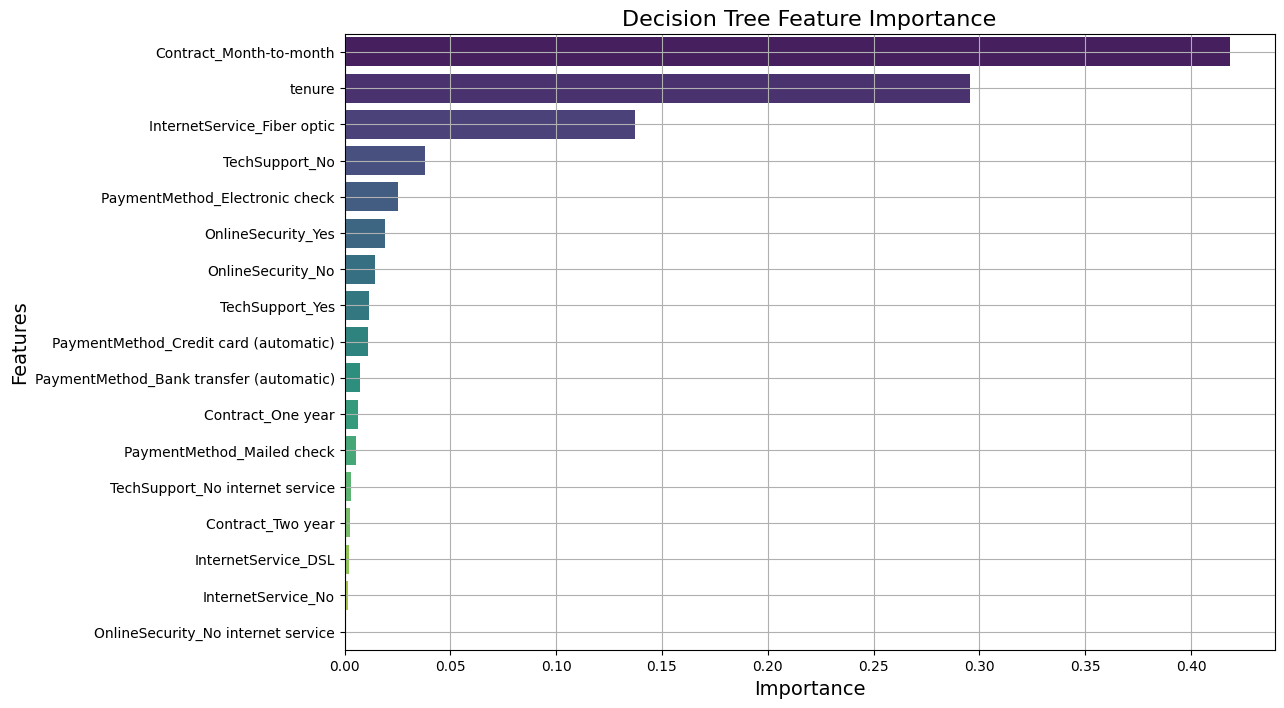

In [38]:
# 최적 모델에서 Feature Importance 추출
feature_importances = dt_best_model.feature_importances_

# Feature Importance를 시리즈로 변환 및 시각화
feature_importance_series = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance_series.values, y=feature_importance_series.index, palette="viridis")
plt.title('Decision Tree Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(True)
plt.show()

<ipython-input-39-bbc000bd9221>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_series.values, y=feature_importance_series.index, palette="viridis")


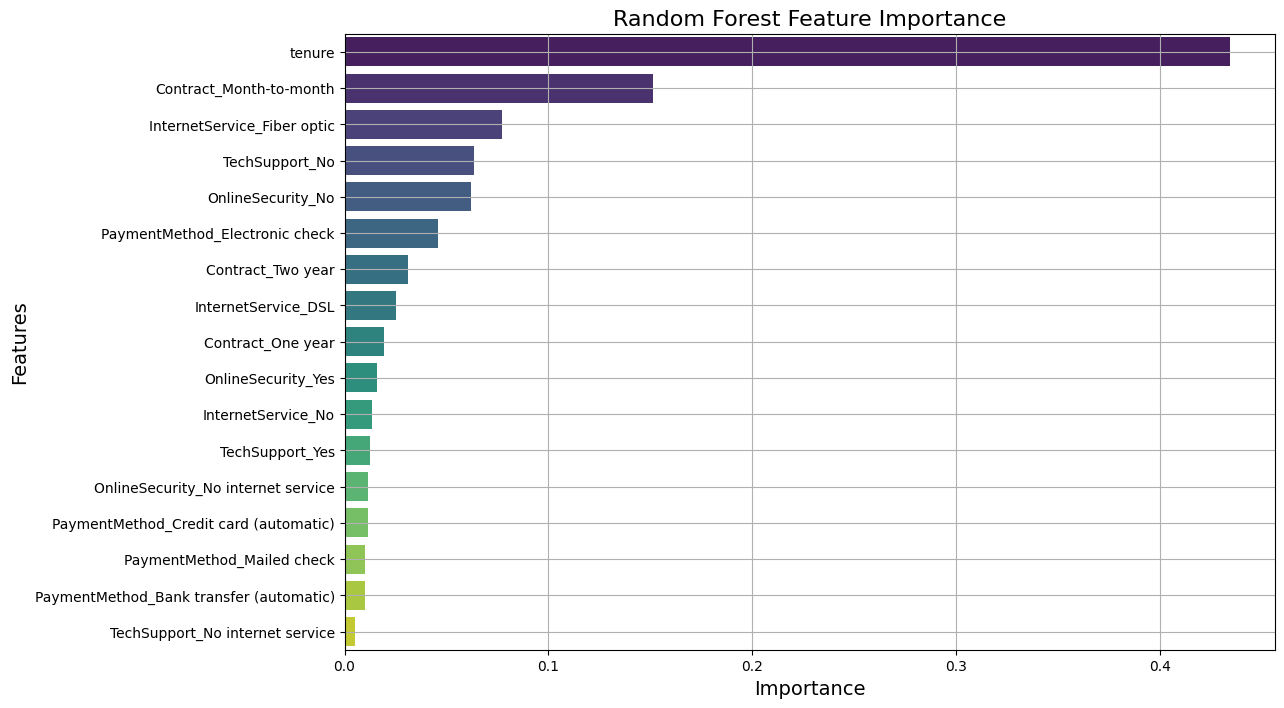

In [39]:
# 최적 모델에서 Feature Importance 추출
feature_importances = rf_best_model.feature_importances_

# Feature Importance를 시리즈로 변환 및 시각화
feature_importance_series = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance_series.values, y=feature_importance_series.index, palette="viridis")
plt.title('Random Forest Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(True)
plt.show()

<ipython-input-40-a77b973e947e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_series.values, y=feature_importance_series.index, palette="viridis")


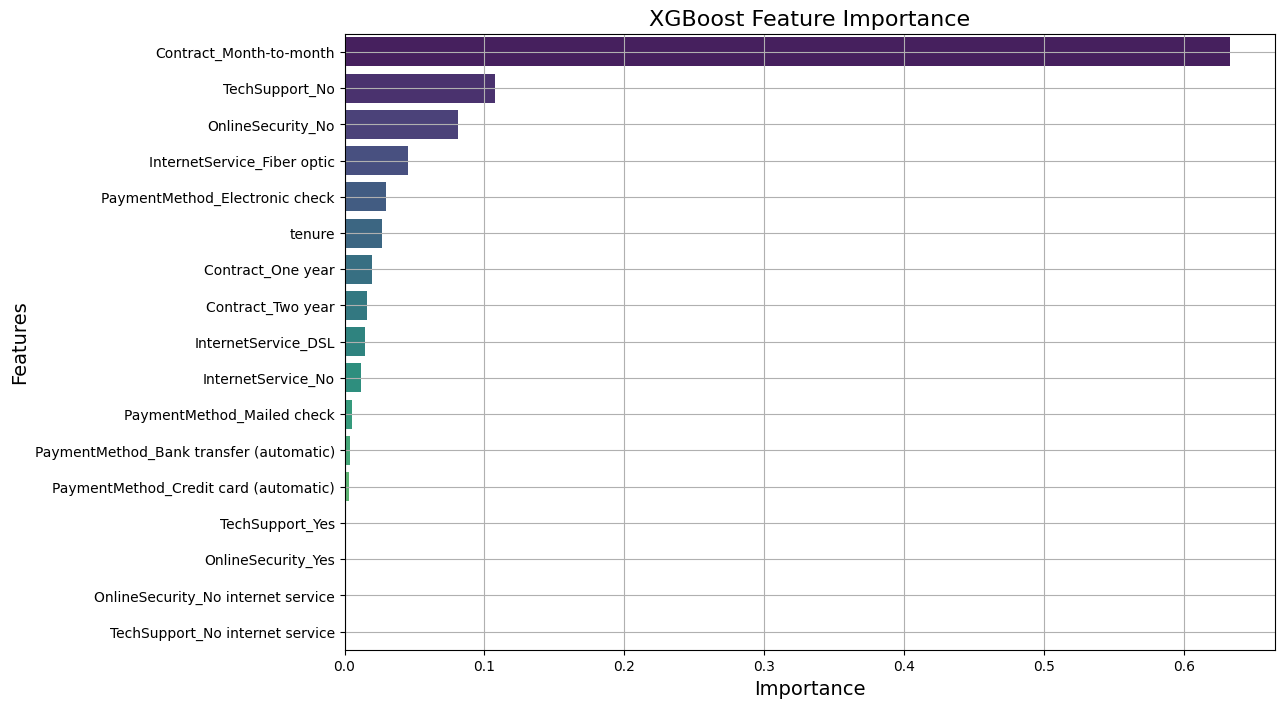

In [40]:
# 최적 모델에서 Feature Importance 추출
feature_importances = xgb_best_model.feature_importances_

# Feature Importance를 시리즈로 변환 및 시각화
feature_importance_series = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance_series.values, y=feature_importance_series.index, palette="viridis")
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(True)
plt.show()

<ipython-input-41-d750281b28ef>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_series.values, y=feature_importance_series.index, palette="viridis")


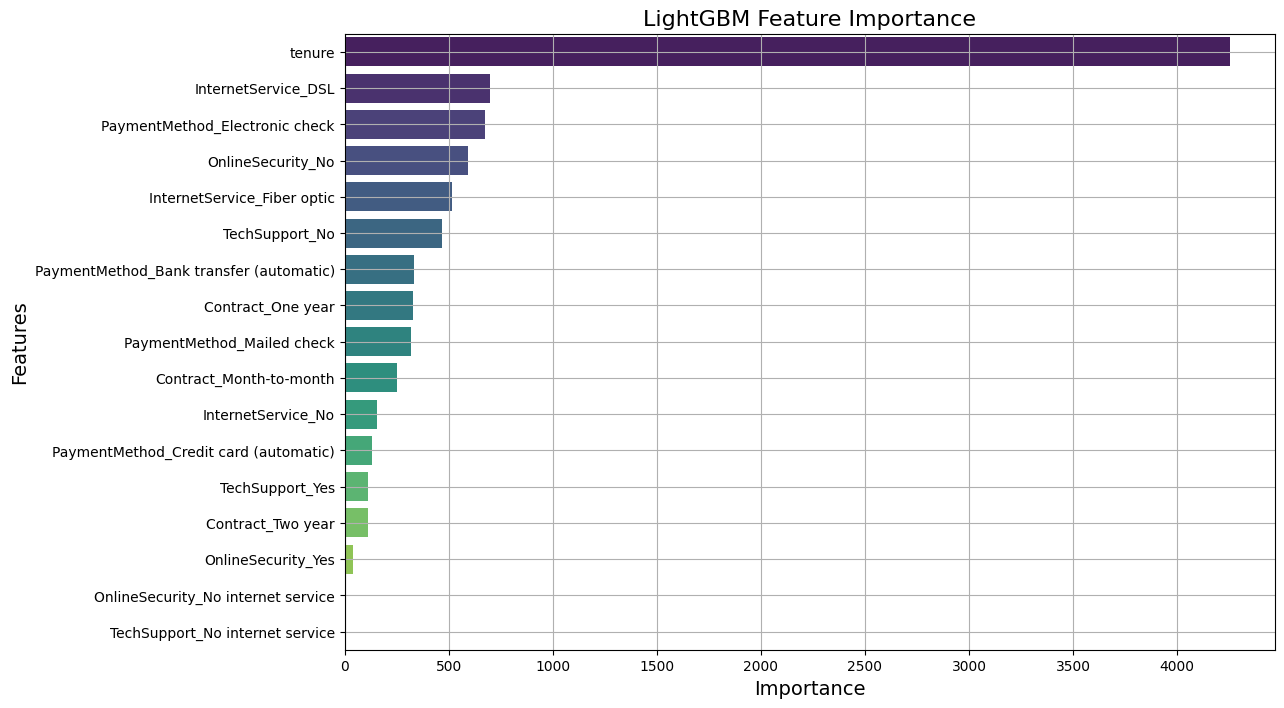

In [41]:
# 최적 모델에서 Feature Importance 추출
feature_importances = lgb_best_model.feature_importances_

# Feature Importance를 시리즈로 변환 및 시각화
feature_importance_series = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance_series.values, y=feature_importance_series.index, palette="viridis")
plt.title('LightGBM Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(True)
plt.show()

## Shapley value

 93%|=================== | 6538/7043 [00:12<00:00]       

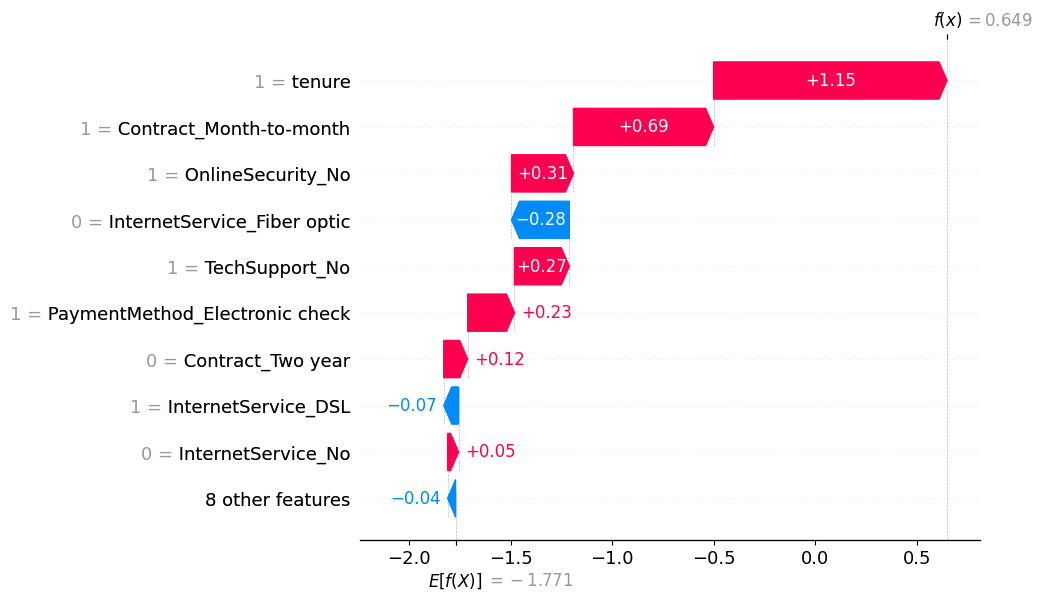

In [62]:
explainer = shap.Explainer(xgb_best_model, X)
shap_values = explainer(X)

# 첫 번째 예측 샘플에 대한 Waterfall plot 시각화
# 다중 출력 모델을 처리하기 위해 첫 번째 출력에 대한 SHAP 값을 선택
if shap_values.values.ndim == 3:
    shap_value_to_plot = shap_values[0, :, 0]
    base_value_to_plot = shap_values.base_values[0, 0]
else:
    shap_value_to_plot = shap_values[0]
    base_value_to_plot = shap_values.base_values[0]

# Waterfall plot 시각화
shap.waterfall_plot(shap.Explanation(values=shap_value_to_plot,
                                     base_values=base_value_to_plot,
                                     data=shap_values.data[0],
                                     feature_names=X.columns))

 97%|=================== | 6849/7043 [00:37<00:01]       

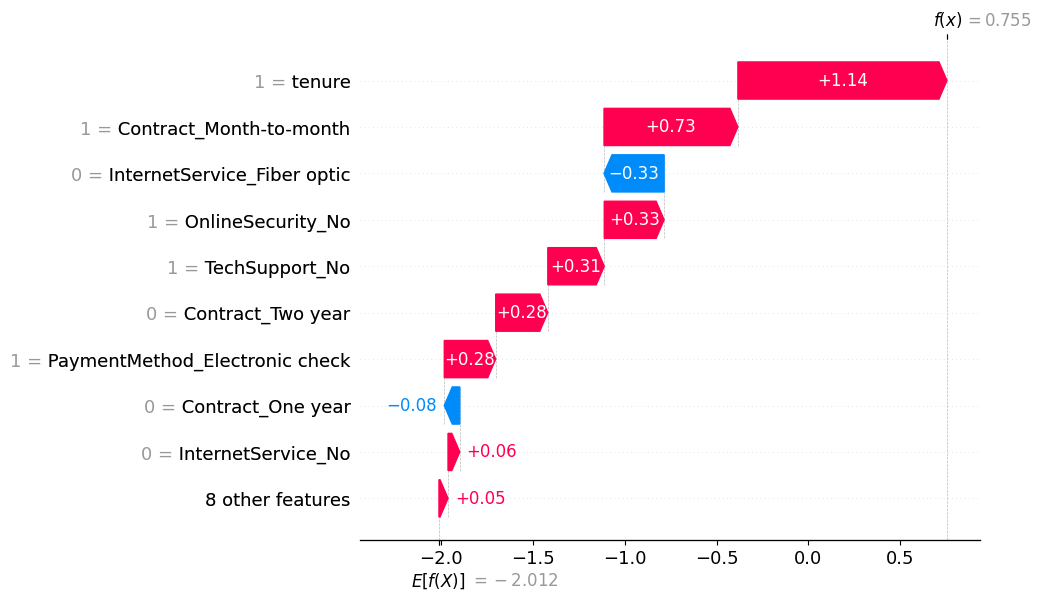

In [64]:
# SHAP explainer 생성 (KernelExplainer 사용)
explainer = shap.Explainer(lgb_best_model, X)
shap_values = explainer(X)

# 첫 번째 예측 샘플에 대한 Waterfall plot 시각화
# 다중 출력 모델을 처리하기 위해 첫 번째 출력에 대한 SHAP 값을 선택
if shap_values.values.ndim == 3:
    shap_value_to_plot = shap_values[0, :, 0]
    base_value_to_plot = shap_values.base_values[0, 0]
else:
    shap_value_to_plot = shap_values[0]
    base_value_to_plot = shap_values.base_values[0]

# Waterfall plot 시각화
shap.waterfall_plot(shap.Explanation(values=shap_value_to_plot,
                                     base_values=base_value_to_plot,
                                     data=shap_values.data[0],
                                     feature_names=X.columns))